In [126]:
%pylab notebook
import cv2
import numpy as np
import utils
from numpy import matrix as mat
np.set_printoptions(formatter={'float':lambda x: '{:8.3f}'.format(x)})

Populating the interactive namespace from numpy and matplotlib


/home/ori/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['mat']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<IPython.core.display.Javascript object>


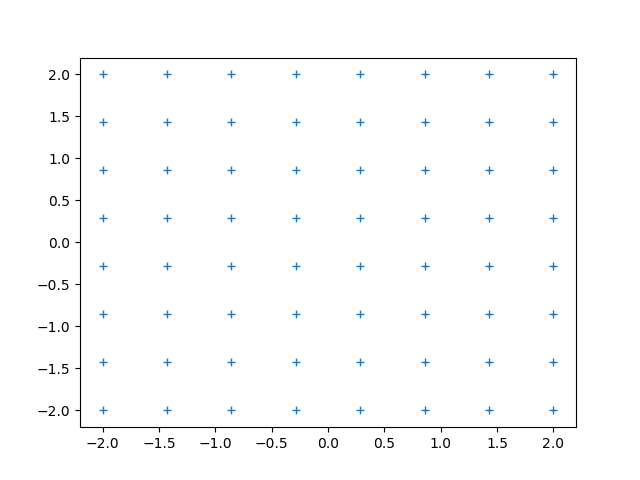

In [391]:
def generate_3d_points():
    ax=np.linspace(-2,2,8)
    xx,yy=np.meshgrid(ax,ax)
    return np.vstack((xx.flatten(),yy.flatten(),np.zeros(len(ax)**2))).T
pts3d=generate_3d_points()
pts3d[:10,:]
figure()
plot(pts3d[:,0],pts3d[:,1],'+')

<IPython.core.display.Javascript object>


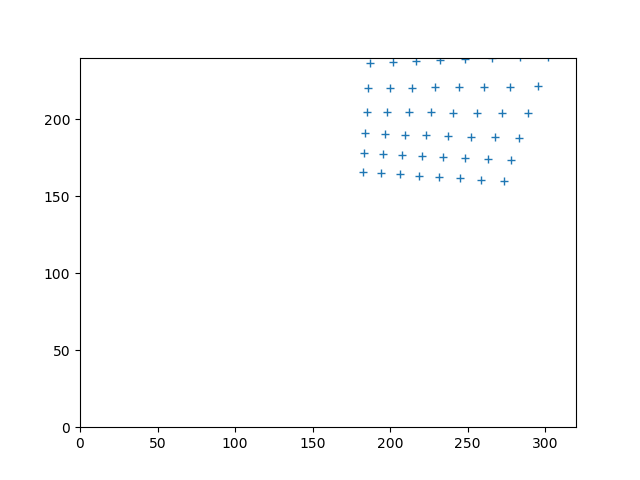

(0, 240)

In [392]:
K=mat([160.0,0,160, 0,160.0,120.0,0,0,1]).reshape(3,3)
x,y,z=1,0,8.0
rx,ry,rz=30/180.0*np.pi,-15/180.0*np.pi,0
R=utils.eulerAnglesToRotationMatrix([rx,ry,rz]) 
C=np.array([x,y,z])
#0=RC+T T=-R.T*C
T=-mat(R).T*mat(C).T
if 1:
    pts=(K*((mat(R).T*pts3d.T).T+T.T).T).T
    pts/=pts[:,2]
    pts=pts[:,:2]
else:
    R_vec,_=cv2.Rodrigues(R.T)
    pts,jac=cv2.projectPoints(pts3d,R_vec,T,K,np.zeros(5))
    pts=pts.reshape(-1,2)
figure()
plot(pts[:,0],pts[:,1],'+')
xlim([0,320])
ylim([0,240])
#(mat(R)*generate_3d_points().T).T

In [393]:
#esimaed camera position 0,0,7 (estimate camera positive altitude) esitmate rotation is 0,0,0
#0=RC+T T=-R.T*C => T=-C
estimate_CamPos=np.array([[   0.0],[   0.0],[   7.0]])
estimate_Rvec=np.array([[   0.0],[   0.0],[   0.0]])
estimate_Tvec=-estimate_CamPos
resPnP,Rvec,Tvec=cv2.solvePnP(pts3d,pts,K,np.zeros(5),estimate_Rvec,estimate_Tvec,True)
Rest,_=cv2.Rodrigues(Rvec)
angs=utils.rotationMatrixToEulerAngles(Rest.T)/np.pi*180
print('calculated camera angles')
print(angs)
print('calculated camera position')
###retriving camera position from translation vector
#0=RC+T C=-R.T*T
print(-mat(Rest).T*Tvec)


calculated camera angles
[  30.000  -15.000   -0.000]
calculated camera position
[[   1.000]
 [   0.000]
 [   8.000]]


In [490]:
#trangulate..
K=mat([160.0,0,160, 0,160.0,120.0,0,0,1]).reshape(3,3)
C1=np.array([0,0,3.0])
C2=np.array([0,1,8.0])

###Camera 1
r1x,r1y,r1z=0.00,0.00,0
R1=utils.eulerAnglesToRotationMatrix([r1x,r1y,r1z]) 
R1_vec,_=cv2.Rodrigues(R1)

###Camera 2
r2x,r2y,r2z=0.02,0.00,0
R2=utils.eulerAnglesToRotationMatrix([r2x,r2y,r2z]) 
R2_vec,_=cv2.Rodrigues(R2)

#knowing camera position calculating T vev
#0=RC+T T=-R*C
T1=-mat(R1)*mat(C1).T
T2=-mat(R2)*mat(C2).T

if 0: #option 1 using distortion coeff
    pts1,_=cv2.projectPoints(pts3d,R1_vec,T1,K,np.zeros(5))
    pts1=pts1.reshape(-1,2)
    pts2,_=cv2.projectPoints(pts3d,R2_vec,T2,K,np.zeros(5))
    pts2=pts2.reshape(-1,2)
else: #option 2 using distortion coeff
    pts1=(K*((mat(R1)*pts3d.T).T+T1.T).T).T
    pts1/=pts1[:,2]
    pts1=pts1[:,:2].A.reshape(-1,2).copy()
    pts2=(K*((mat(R2)*pts3d.T).T+T2.T).T).T
    pts2/=pts2[:,2]
    pts2=pts2[:,:2].A.reshape(-1,2).copy()

if 0:
    figure()
    subplot(1,2,1)
    plot(pts1[:,0],pts1[:,1],'+')
    xlim([0,320])
    ylim([0,240])
    subplot(1,2,2)
    plot(pts2[:,0],pts2[:,1],'+')
    xlim([0,320])
    ylim([0,240])
#_pts1-pts1
#type(pts2b)==type(pts2)

T= [  -0.000    0.176    0.984]
R= [[   1.000    0.000    0.000]
 [  -0.000    1.000   -0.020]
 [  -0.000    0.020    1.000]]
trans= [  -0.000    1.000    5.000]


<IPython.core.display.Javascript object>


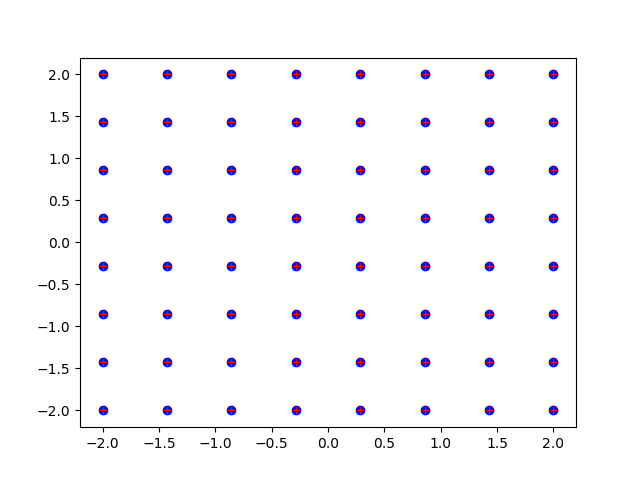

'\nT= [  -0.000    0.071    0.998]\nR= [[   1.000   -0.000    0.000]\n [  -0.000    0.987    0.161]\n [  -0.000   -0.161    0.987]]\ntrans= [  -0.000   -0.455    5.000]\n'

In [491]:
E,mask=cv2.findEssentialMat(pts1,pts2,K,cv2.RANSAC,0.99,1.0)
#E,mask=cv2.findEssentialMat(pts1,pts2,K,cv2.LMEDS,0.99,1.0) 
ret,R,T,mask=cv2.recoverPose(E,pts1,pts2,K,mask)
T=T.ravel()
print('T=',T)
print('R=',R)
estimated_alt=C2[2]-C1[2]
trans_T=(-mat(R).T*mat(T).T).A1
trans=np.array([trans_T[0]/trans_T[2], trans_T[1]/trans_T[2], 1.0]) * estimated_alt 
print('trans=',trans)
trans=(mat(R)*mat(trans).T).A1


distortion=np.zeros(5)

p1=cv2.undistortPoints(pts1.reshape(-1,1,2),K,distortion).reshape(-1,2)
p2=cv2.undistortPoints(pts2.reshape(-1,1,2),K,distortion).reshape(-1,2)

#todo: not use C but the translation of each camera
Proj1=np.hstack((np.eye(3),np.zeros((3,1))))
#Proj2=np.hstack((R,-trans.reshape((3,1))))
Proj2=np.hstack((R,-trans.reshape((3,1))))

pts3d_trang=cv2.triangulatePoints(Proj2,Proj1,p2.T,p1.T)
pts3d_trang=pts3d_trang/pts3d_trang[3,:]
figure()
plot(pts3d_trang.T[:,0],pts3d_trang.T[:,1],'ob')
plot(pts3d[:,0],pts3d[:,1],'+r')
pts3d_trang.T[:,2]
#plot(p1[:,0],p1[:,1],'+')
#p2.T[:4,:]
